In [1]:
# File Processing Imports
import os
CWD = os.getcwd()
print(CWD)
import shutil
import PIL
from PIL import Image

# ML-related imports
import numpy as np
import pandas as pd
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

/mnt/e/APResearch/code-AP-Research-Project


2024-01-04 23:05:51.690471: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# ResNet50V2
Adapted from https://www.tensorflow.org/tutorials/images/classification

## Set training Dataset

In [8]:
# Options
#TRAINING_SET = "ISIC-2017" 
#TRAINING_SET = "ISIC-2017_DEARTIFACTED"
#TRAINING_SET = "DDI-2022"
#TRAINING_SET = "DDI-2022_DEARTIFACTED"
TRAINING_SET = "COMBINED_DDI-2022_ISIC-2017"

training_directory = f'{CWD}/datasets/{TRAINING_SET}/classified_images'

## Compile Training Dataset

In [9]:
# Set train and validation datasets
"""
Tunable hyperparameters:
batch_size -> set size of batches put into the model.
              in case of OOM (out of memory) error, reduce this value
seed -> changes randomization of dataset sampling. 
        Set to 123 for consistency across training.
validation_split -> changes percentage of data set aside for validation. 
                    80-20 training-validation split employed for now, but can be changed.
"""
train_ds = trainset = keras.utils.image_dataset_from_directory(
    directory=training_directory,
    labels="inferred",
    batch_size=32, 
    image_size=(224,224),
    seed = 123,
    validation_split=0.2,
    subset="training",
    )

val_ds = keras.utils.image_dataset_from_directory(
    directory=training_directory,
    labels="inferred",
    batch_size=32, 
    image_size=(224,224),
    seed = 123,
    validation_split=0.2,
    subset="validation",
    )

Found 1098 files belonging to 2 classes.
Using 879 files for training.
Found 1098 files belonging to 2 classes.
Using 219 files for validation.


In [11]:
# Sanity Checks, ensuring our data was properly loaded
class_names = train_ds.class_names
print(class_names) # should return ['benign', 'malignant']

for image_batch, labels_batch in train_ds:
  print(image_batch.shape) # first value in this tuple should match
  print(labels_batch.shape) # the only value in this tuple
  break

['benign', 'malignant']
(32, 224, 224, 3)
(32,)


2024-01-04 23:07:51.203382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [879]
	 [[{{node Placeholder/_4}}]]
2024-01-04 23:07:51.203685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [879]
	 [[{{node Placeholder/_0}}]]


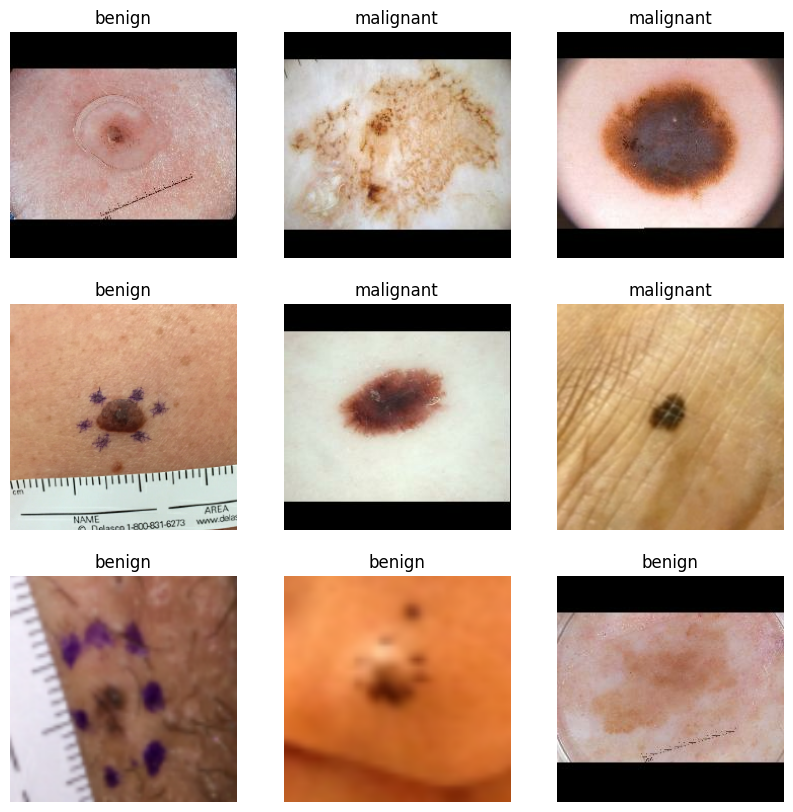

In [12]:
# Observing some images from our dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Load ResNet50V2 Model

In [13]:
# Efficiency preprocessing for datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Augment training dataset with random rotations
augment_rotation = tf.keras.layers.RandomRotation(
    factor = (0, 1), # allows for a full 2pi radians of rotations
    seed = 123 # defined for a little extra consistency
    ) 
train_ds = train_ds.map(lambda x, y: (augment_rotation(x),y))

In [14]:
# Load ResNet50V2 using Keras applications
i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
core = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights="imagenet", # Utilizing Transfer Learning, also maintains consistency
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

x = core(x)
model = tf.keras.Model(inputs=[i], outputs=[x])

In [ ]:
# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

In [ ]:
# Train model
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
# Visualize Training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.axis([0, 50, 0, 1.0])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.axis([0, 50, 0, 20])
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model = model # Get model (Sequential, Functional Model, or Model subclass)
model.save(f'{CWD}/models/ResNet50V2_{TRAINING_SET}.keras')  # The file needs to end with the .keras extension

In [19]:
# Clear Session -> for memory management reasons
keras.backend.clear_session()